In [1]:
import os, requests, random, re
import torch
import fitz #from PyMuPDF
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import textwrap
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig
from transformers.utils import is_flash_attn_2_available
from spacy.lang.en import English
from sentence_transformers import util, SentenceTransformer
from time import perf_counter as timer

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
pdf_path = "sp287.pdf"

if not os.path.exists(pdf_path):
    print("[INFO] File doesn't exists, downloading...")

    url = "https://archive.org/download/what-made-apollo-a-success/What%20made%20Apollo%20a%20success.pdf"

    filename = pdf_path

    response = requests.get(url)

    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"[INFO] The file has been downloaded and saved as {filename}")
    else:
        print(f"[INFO] Failed to download the file. Status code: {response.status_code}")
else:
    print(f"File {pdf_path} exists.")

File sp287.pdf exists.


In [3]:
def text_formatter(text: str) -> str:
    # Performs minor formatting on text.
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []

    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({"page_number": page_number - 2,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4, # 1 token = ~4 char
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
#pages_and_texts[:2]

0it [00:00, ?it/s]

In [4]:
#random.sample(pages_and_texts, k=3)

In [5]:
df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-2,258,34,3,64.50,This text has been compiled from source by a v...
1,-1,859,138,49,214.75,SP-287 What Made Apollo a Success? [iii] CON...
2,0,1709,249,47,427.25,3-II. COMMAND AND SERVICE MODULE ACCEPTANCE VI...
3,1,1775,261,47,443.75,structure takes loads imposed in 2-1/2g pullup...
4,2,339,50,7,84.75,SP-287 What Made Apollo a Success? 1. INTRODUC...


In [6]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,105.00,105.00,105.00,105.00,105.00
mean,50.00,1551.27,240.10,14.10,387.82
std,30.45,615.81,97.21,8.07,153.95
min,-2.00,56.00,8.00,2.00,14.00
25%,24.00,1130.00,172.00,10.00,282.50
50%,50.00,1722.00,260.00,13.00,430.50
75%,76.00,2030.00,314.00,16.00,507.50
max,102.00,2417.00,398.00,49.00,604.25


In [7]:
nlp = English()

# sentencizer pipeline https://spacy.io/api/sentencizer
nlp.add_pipe("sentencizer")

doc = nlp("This is a sentence. This is another. I like cats.")
assert len(list(doc.sents)) == 3

list(doc.sents)

[This is a sentence., This is another., I like cats.]

In [8]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # default is spaCy dt, this makes sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/105 [00:00<?, ?it/s]

In [9]:
#random.sample(pages_and_texts, k=1)

In [10]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,105.00,105.00,105.00,105.00,105.00,105.00
mean,50.00,1551.27,240.10,14.10,387.82,13.48
std,30.45,615.81,97.21,8.07,153.95,6.93
min,-2.00,56.00,8.00,2.00,14.00,2.00
25%,24.00,1130.00,172.00,10.00,282.50,10.00
50%,50.00,1722.00,260.00,13.00,430.50,13.00
75%,76.00,2030.00,314.00,16.00,507.50,16.00
max,102.00,2417.00,398.00,49.00,604.25,47.00


In [11]:
# langchain can help with this
num_sentence_chunk_size = 10

def split_list(input_list: list,
               slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [12]:
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/105 [00:00<?, ?it/s]

In [13]:
#random.sample(pages_and_texts, k=1)

In [14]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,105.00,105.00,105.00,105.00,105.00,105.00,105.00
mean,50.00,1551.27,240.10,14.10,387.82,13.48,1.80
std,30.45,615.81,97.21,8.07,153.95,6.93,0.74
min,-2.00,56.00,8.00,2.00,14.00,2.00,1.00
25%,24.00,1130.00,172.00,10.00,282.50,10.00,1.00
50%,50.00,1722.00,260.00,13.00,430.50,13.00,2.00
75%,76.00,2030.00,314.00,16.00,507.50,16.00,2.00
max,102.00,2417.00,398.00,49.00,604.25,47.00,5.00


In [15]:
# split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # join sentences into paragraph
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        # at a capital letter after period/q-mark, add space
        joined_sentence_chunk = re.sub(r'([.?])([A-Z])', r'\1 \2', joined_sentence_chunk)

        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/105 [00:00<?, ?it/s]

189

In [16]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 45,
  'sentence_chunk': 'Support structure takes loads imposed in 2-1/2g pull-up, after which zero g is achieved for 20 to 30 seconds on a parabolic ﬂight path. [34] [PICTURE MISSING] Figure 4-4. Familiarization run on the mobile partial-gravity simulator used for lunar walk indoctrination.\xa0 NAVIGATION, GUIDANCE AND CONTROL PROCEDURES [36] INFLIGHT PHOTOGRAPHY [PICTURE MISSING] Figure 4-5. Apollo 12 landing and ascent model of Surveyor and Snowman craters as seen from 1800 feet. SIMULATION [PICTURE MISSING] Figure 4-6. Command module procedures simulator and lunar module procedures simulator.\xa0 [PICTURE MISSING] Figure 4-8. Dynamics crew procedures simulator. [PICTURE MISSING] Figure 4-7.',
  'chunk_char_count': 671,
  'chunk_word_count': 95,
  'chunk_token_count': 167.75}]

In [17]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,189.00,189.00,189.00,189.00
mean,48.43,860.26,132.31,215.07
std,30.96,478.49,75.31,119.62
min,-2.00,6.00,2.00,1.50
25%,21.00,426.00,63.00,106.50
50%,47.00,904.00,134.00,226.00
75%,75.00,1203.00,190.00,300.75
max,102.00,2036.00,316.00,509.00


In [18]:
df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,-2,This text has been compiled from source by a v...,258,34,64.50
1,-1,SP-287 What Made Apollo a Success? [iii] CONT...,219,33,54.75
2,-1,"4. APOLLO CREW PROCEDURES, SIMULATION, AND FLI...",260,41,65.00
3,-1,TECHNIQUES OF CONTROLLING THE TRAJECTORY. By H...,368,54,92.00
4,0,3-II. COMMAND AND SERVICE MODULE ACCEPTANCE VI...,368,50,92.00


In [19]:
#filter for chunks under 20 tokens
min_token_length = 20
for row in df[df["chunk_token_count"] < min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 1.5 | Text: Yet, a
Chunk token count: 17.5 | Text: The computer complex and inﬁnity-optics system from the Gemini mission
Chunk token count: 14.0 | Text: moon. The reports which follow amplify this observation.
Chunk token count: 5.0 | Text: The Board considered
Chunk token count: 16.0 | Text: For example.early in the program both the launch vehicle and the


In [20]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -2,
  'sentence_chunk': 'This text has been compiled from source by a volunteer, not NASA. The original source was missing some images which are tagged as [MISSING IMAGE]. Original source: https://history.nasa.gov/ SP-287/sp287.htm For further information E-mail histinfo@hq.nasa.gov',
  'chunk_char_count': 258,
  'chunk_word_count': 34,
  'chunk_token_count': 64.5},
 {'page_number': -1,
  'sentence_chunk': 'SP-287 What Made Apollo a Success?\xa0 [iii] CONTENTS \xa0 \xa0 1. INTRODUCTION. By George M. Low.2. DESIGN PRINCIPLES STRESSING SIMPLICITY. By Kenneth S. Kleinknecht.3. TESTING TO ENSURE MISSION SUCCESS. By Scott H. Simpkinson.',
  'chunk_char_count': 219,
  'chunk_word_count': 33,
  'chunk_token_count': 54.75}]

In [21]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': 45,
  'sentence_chunk': 'Translation and docking trainer simulates lunar module active docking over last 100 feet of separation distance. [PICTURE MISSING] Figure 4-9. Simulated command module crew station for the dynamics crew procedures simulator. [38] [PICTURE MISSING] Figure 4-10. Lunar module mission simulator with crew station and Farrand optical systems for three windows. [PICTURE MISSING] Figure 4-11. Visual optics and instructor station for command module mission simulator. [PICTURE MISSING] Figure 4-12. Apollo 12 landing and ascent visual simulation system.\xa0 FLIGHT PLANNING',
  'chunk_char_count': 565,
  'chunk_word_count': 78,
  'chunk_token_count': 141.25}]

In [22]:
### Everything above could be handled by Langchain, as most of it is simply preprocessing the data and creating smaller chunks to create context for the model

In [23]:
# embed text chunks
# can use any from here https://sbert.net/docs/pretrained_models.html or huggingface
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                     device=device)
#embedding_model = SentenceTransformer(model_name_or_path="mixedbread-ai/mxbai-embed-large-v1",
#                                     device=device)

# create list of sentences
sentences = ["The Sentence Transformer library provides an easy way to create embeddings",
             "Sentences can be embedded 1 by 1 or in a list.",
             "I like cats."]

# embed/encode sentences
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# display embeddings
for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print("")

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence: The Sentence Transformer library provides an easy way to create embeddings
Embedding: [-3.17512266e-02  3.37268114e-02 -2.52437796e-02  5.22287413e-02
 -2.35249065e-02 -6.19115494e-03  1.35026174e-02 -6.25501126e-02
  7.50826672e-03 -2.29684655e-02  2.98146587e-02  4.57554795e-02
 -3.26700360e-02  1.39847128e-02  4.18013930e-02 -5.92969730e-02
  4.26309928e-02  5.04658557e-03 -2.44552568e-02  3.98593815e-03
  3.55897471e-02  2.78742611e-02  1.84098464e-02  3.67699936e-02
 -2.29960829e-02 -3.01796980e-02  5.99524763e-04 -3.64503860e-02
  5.69104478e-02 -7.49940239e-03 -3.70004401e-02 -3.04357894e-03
  4.64354604e-02  2.36149807e-03  9.06849777e-07  7.00035132e-03
 -3.92289795e-02 -5.95699204e-03  1.38652911e-02  1.87109306e-03
  5.34202382e-02 -6.18613586e-02  2.19613295e-02  4.86051030e-02
 -4.25697751e-02 -1.69858877e-02  5.04178703e-02  1.54733490e-02
  8.12859684e-02  5.07106520e-02 -2.27497090e-02 -4.35720980e-02
 -2.18386226e-03 -2.14091707e-02 -2.01757997e-02  3.0683217

In [24]:
%%time

embedding_model.to(device)
# embed each chunk
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

# embedding in batches
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32,
                                               convert_to_tensor=True)
text_chunk_embeddings

  0%|          | 0/184 [00:00<?, ?it/s]

CPU times: user 11.7 s, sys: 27.7 ms, total: 11.7 s
Wall time: 2.08 s


tensor([[ 0.0658, -0.0746,  0.0201,  ...,  0.0098,  0.0060, -0.0109],
        [-0.0035, -0.0597,  0.0139,  ...,  0.0823,  0.0191,  0.0020],
        [ 0.0065, -0.0604,  0.0184,  ...,  0.0521,  0.0329, -0.0141],
        ...,
        [ 0.0627, -0.0022,  0.0398,  ...,  0.0689, -0.0011, -0.0081],
        [ 0.0569, -0.0397,  0.0040,  ...,  0.0422, -0.0359, -0.0059],
        [ 0.0211, -0.0032,  0.0054,  ...,  0.0550, -0.0193, -0.0323]],
       device='cuda:0')

In [25]:
# save embeds to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [26]:
# import annd view saved file
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-2,This text has been compiled from source by a v...,258,34,64.50,[ 6.57722652e-02 -7.46045560e-02 2.01327372e-...
1,-1,SP-287 What Made Apollo a Success? [iii] CONT...,219,33,54.75,[-3.46447038e-03 -5.97067922e-02 1.38992239e-...
2,-1,"4. APOLLO CREW PROCEDURES, SIMULATION, AND FLI...",260,41,65.00,[ 6.50862651e-03 -6.03714921e-02 1.84208620e-...
3,-1,TECHNIQUES OF CONTROLLING THE TRAJECTORY. By H...,368,54,92.00,[ 4.37398031e-02 -2.02097744e-02 1.15017425e-...
4,0,3-II. COMMAND AND SERVICE MODULE ACCEPTANCE VI...,368,50,92.00,[ 1.28367813e-02 -1.05223350e-01 7.43722357e-...


### RAG Search and Answer

In [27]:
# import texts and embedding df
text_chunks_and_embeddings_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

#convert embedding column back to np.array
text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device
embeddings = torch.tensor(np.array(text_chunks_and_embeddings_df["embedding"].tolist()), dtype=torch.float32).to(device)

text_chunks_and_embeddings_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-2,This text has been compiled from source by a v...,258,34,64.50,"[0.0657722652, -0.074604556, 0.0201327372, -0...."
1,-1,SP-287 What Made Apollo a Success? [iii] CONT...,219,33,54.75,"[-0.00346447038, -0.0597067922, 0.0138992239, ..."
2,-1,"4. APOLLO CREW PROCEDURES, SIMULATION, AND FLI...",260,41,65.00,"[0.00650862651, -0.0603714921, 0.018420862, -0..."
3,-1,TECHNIQUES OF CONTROLLING THE TRAJECTORY. By H...,368,54,92.00,"[0.0437398031, -0.0202097744, 0.0115017425, -0..."
4,0,3-II. COMMAND AND SERVICE MODULE ACCEPTANCE VI...,368,50,92.00,"[0.0128367813, -0.10522335, 0.00743722357, 2.5..."
...,...,...,...,...,...,...
179,99,During the period from late 1967 to early 1968...,177,30,44.25,"[-0.0141883679, 0.022350423, -0.00153109909, -..."
180,100,"mission. After the ﬁrst two Saturn IB ﬂights, ...",2030,314,507.50,"[0.0291505884, -0.049860239, 0.00843922049, -0..."
181,101,spacecraft had development objectives which ha...,1033,152,258.25,"[0.0627361611, -0.00220377231, 0.0398465581, -..."
182,101,The basic mission-planning documents which the...,854,120,213.50,"[0.0568552017, -0.039650321, 0.00404073903, -0..."


In [28]:
embeddings.shape

torch.Size([184, 768])

In [29]:
# create embedding
#embedding_model = SentenceTransformer(model_name_or_path="mixedbread-ai/mxbai-embed-large-v1",
#                                    device=device)
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                    device=device)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [30]:
# define query
query = "mission rules"
print(f"Query: {query}")

# embed query (embed query with same model you embed passages)
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)
query_embedding = query_embedding.unsqueeze(0)

# get similarity scores with dot product (cosine similarity if outputs are not normalized)
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
#dot_scores = util.cos_sim(query_embedding, embeddings)
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# get top-k results (top 5, https://pytorch.org/docs/stable/generated/torch.topk.html )
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: mission rules
[INFO] Time taken to get scores on 184 embeddings: 0.00013 seconds.


torch.return_types.topk(
values=tensor([0.5167, 0.4992, 0.4989, 0.4879, 0.4758], device='cuda:0'),
indices=tensor([120, 117, 181, 160, 114], device='cuda:0'))

In [31]:
print("Query Embedding Shape:", query_embedding.shape)
print("Query Embedding Type:", query_embedding.dtype)
print("Embeddings Shape:", embeddings.shape)
print("Embeddings Type:", embeddings[0].dtype)

Query Embedding Shape: torch.Size([1, 768])
Query Embedding Type: torch.float32
Embeddings Shape: torch.Size([184, 768])
Embeddings Type: torch.float32


In [32]:
def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [33]:
query = "lunar surface"
print(f"Query: '{query}'\n")
print("Results:")
# loop through torch.topk results
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'lunar surface'

Results:
Score: 0.5167
Text:
The speciﬁc format for mission rules has remained the same since Project
Mercury. A short statement describes the condition or malfunction which may
require action. The ruling follows. A third section of the rule contains
applicable notes, comments, or standard operating procedures. Documents
carefully delineate the reasoning behind each mission rule, including tradeoﬀs
which may not be otherwise apparent. Standard operating procedures receive as
careful attention. They divide into interface procedures and personal
procedures. Interface procedures include all ﬂight control procedures involving
more than two console positions. Together, the procedures comprise the Flight
Control Operations Handbook (FCOH). Like the mission [48] rules, the FCOH
procedures appear in a standard format and are as brief as possible without
becoming ambiguous.
Page number: 66


Score: 0.4992
Text:
spacecraft systems. They do this parameter by parameter, ass

May use https://huggingface.co/mixedbread-ai/mxbai-rerank-large-v1 for a reranker here
Could also look into https://docs.haystack.deepset.ai/docs/rankers

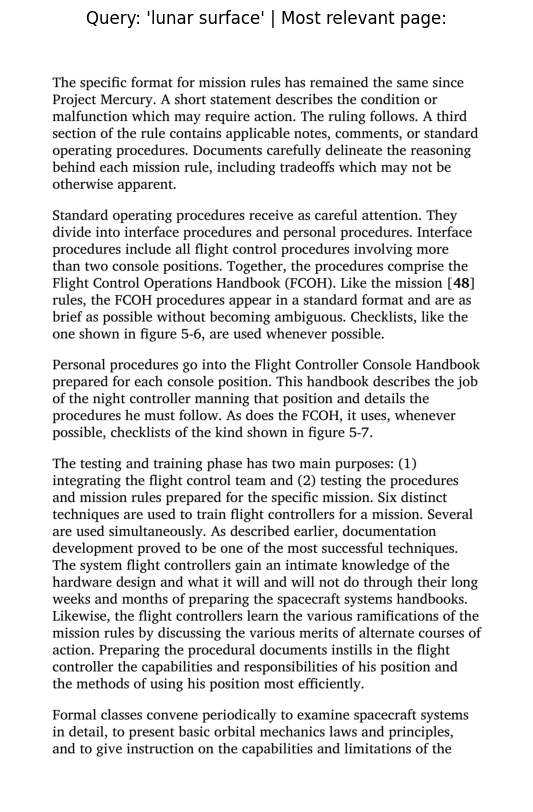

In [34]:
# open pdf and loadd target
pdf_path = "sp287.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(66 + 2)

# get image of page
img = page.get_pixmap(dpi=300)

#save image
#img.save("output_filename.png")
doc.close()

#convert pixmap to array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

#dispaly image
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis("off")
plt.show()

# Semantic Search Pipeline

In [35]:
# numpy can't use gpu (though CuPy could), pytorch can
# may save these functions to .py file to import in
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5, #passages
                                print_time: bool=True):

    #Embeds a query with model and returns top k scores and indices from embeddings.
    query_embedding = model.encode(query, convert_to_tensor=True)

    # get dot product scores on embeddings
    # could save this to file ahead of time so you don't need to create the embeddings, just a function to import them
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on ({len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):

    # Finds relevant passages given a query and prints them out along with their scores.
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    # loop through torch.topk results
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[idx]['page_number']}")
        print("\n")

### Getting LLM
- https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard (leaderboard of models)
- https://huggingface.co/TheBloke (gives quantized versions of models)

In [36]:
#check gpu memory availability
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")
#as long as this number is 8+ you can use flash_attn, if it's not then comment it out in the cell below
torch.cuda.get_device_capability(0)[0]
#!nvidia-smi
# Neat tester for usage
#if gpu_memory_gb < 5.1:
#    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
#elif gpu_memory_gb < 8.1:
#    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
#    use_quantization_config = True 
#    model_id = "google/gemma-2b-it"
#elif gpu_memory_gb < 19.0:
#    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
#    use_quantization_config = False 
#    model_id = "google/gemma-2b-it"
#elif gpu_memory_gb > 19.0:
#    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
#    use_quantization_config = False 
#    model_id = "google/gemma-7b-it"
#print(f"use_quantization_config set to: {use_quantization_config}")
#print(f"model_id set to: {model_id}")

Available GPU memory: 10 GB


8

In [37]:
# if memory is constrained, use quantization config to decide on model precision to load in
# look into using flash_attn https://github.com/Dao-AILab/flash-attention to speed up token generation of llm
# note use of https://github.com/TimDettmers/bitsandbytes
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# flash_attn requires compute capability score of 8.0+ (see https://developer.nvidia.com/cuda-gpus ), can also see cell above
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
    attn_implementation = "flash_attention_2"
else:
    # https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html
    attn_implementation = "sdpa"
print(f"Using attention implementation: {attn_implementation}")

# using models with -it (means instruction tuned) might be better for this
model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
use_quantization_config = False
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                torch_dtype=torch.float16,
                                                quantization_config=quantization_config if use_quantization_config else None,
                                                low_cpu_mem_usage=False, #use as much memory as possible
                                                attn_implementation=attn_implementation)

if not use_quantization_config:
    llm_model.to("cuda")

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Using attention implementation: flash_attention_2


In [38]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

def get_model_mem_size(model: torch.nn.Module):
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])
    # Calculate model sizes
    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

model_mem_info = get_model_mem_size(llm_model)
model_mem_bytes = model_mem_info["model_mem_bytes"]
model_mem_mb = model_mem_info["model_mem_mb"]
model_mem_gb = model_mem_info["model_mem_gb"]

# because there's calculations that take place in the forward pass, assume a few extra GB needed https://epochai.org/blog/estimating-training-compute
print(f"Loaded Model Parameters: {get_model_num_params(llm_model)}")
print(f"Loaded Model Memory (bytes): {model_mem_bytes}")
print(f"Loaded Model Memory (MB): {model_mem_mb:.2f}")
print(f"Loaded Model Memory (GB): {model_mem_gb:.2f}")

Loaded Model Parameters: 1100048384
Loaded Model Memory (bytes): 2215828224
Loaded Model Memory (MB): 2113.18
Loaded Model Memory (GB): 2.06


### llm generation
In the model cards, it should tell you the instruction template for best results (for inference)

In [39]:
gpt4_questions = [
    "What are the maximum allowable concentrations of carbon monoxide in spacecraft environments?",
    "How does NASA SP-287 address the potential health effects of prolonged exposure to airborne formaldehyde in spacecraft?",
    "What methods are recommended for monitoring and controlling airborne ammonia levels aboard spacecraft?",
    "According to NASA SP-287, what are the safety thresholds for airborne benzene, and what are the potential risks associated with exceeding these levels?",
    "How does NASA SP-287 define the permissible exposure limits for volatile organic compounds (VOCs) in a spacecraft, and what mitigation strategies are suggested?"
]

manual_questions = [
    "What is the purpose of NASA's SP-287 document?",
    "How does NASA SP-287 define safe air quality for astronauts in space?",
    "What are some common contaminants that NASA SP-287 addresses?",
    "Why is it important to control air quality in spacecraft?",
    "What methods are suggested by NASA SP-287 for monitoring air quality in space missions?"
]

query_list = gpt4_questions + manual_questions

### Augment prompt with context items
- Neat guide for prompting https://github.com/brexhq/prompt-engineering
- Can also look over https://www.promptingguide.ai/
- Paper for prompt engineering https://arxiv.org/abs/2401.14423
- Good article to read https://www.anthropic.com/news/prompt-engineering-for-business-performance

A few of the useful things from above:
1. Give clear instructions
2. Give a few examples of input/output (given this input, I'd like this output)
3. Give room to think (such as "create a notepad", "show your work", "let's think step by step", etc)

In [40]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    with open("base_prompt.txt", "r") as file:
        base_prompt = file.read()

    base_prompt = base_prompt.format(context=context,
                                     query=query)

    # create prompt template
    dialogue_template = [
        {"role": "user",
         "content": base_prompt}
    ]

    #apply chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                           tokenize=False,
                                           add_generation_prompt=True)
    return prompt

query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

# create list of context itemss
context_items = [pages_and_chunks[i] for i in indices]

#format prompt
prompt = prompt_formatter(query=query,
                          context_items=context_items)

#print(prompt)

Query: What are the maximum allowable concentrations of carbon monoxide in spacecraft environments?
[INFO] Time taken to get scores on (184 embeddings: 0.00003 seconds.


In [41]:
def ask(query: str,
        temperature: float=0.7,
        max_new_tokens: int=256,
        format_answer_text=True,
        return_answer_only=True):

    # RETRIEVAL
    # Get scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()

    # AUGMENT
    # Create prompt and format with context
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # GENERATION
    # Tokenize prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to(device)

    # Generate an output of tokens, could see https://huggingface.co/docs/transformers/en/main_classes/text_generation
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True, # see https://huyenchip.com/2024/01/16/sampling.html
                                 max_new_tokens=max_new_tokens)

    # Decode tokens to text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        output_text = output_text.replace(prompt, "").replace("</s>", "").replace("<|assistant|>\n", "")
        if "###ENDPROMPT###" in output_text:
            output_text = output_text.split("###ENDPROMPT###")[1].strip()

    # Only return answer without context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [42]:
query = random.choice(query_list)
print(f"Query: {query}")
ask(query=query,
    temperature=0.2)

Query: How does NASA SP-287 address the potential health effects of prolonged exposure to airborne formaldehyde in spacecraft?
[INFO] Time taken to get scores on (184 embeddings: 0.00003 seconds.


"NASA's SP-287 document provides guidelines on the maximum allowable concentrations of selected airborne contaminants in spacecraft to ensure the health and safety of astronauts. The main purpose of the document is to provide a framework for controlling air quality in spacecraft, including the following:\n\n1. Environment b 0 to 160 30 to 130 a Equipment thermally isolated for 24 hours at each level.\n2. Qualiﬁcation test limits.\n3. Equipment normally cooled on a cold plate should be mounted on one during the test with the coolant entering the cold plate externally controlled to between 10° and 15° F cooler than the environment.\n4. Of approximately 260 LM and 215 CSM items of deliverable equipment reviewed, 70 LM and 55 CSM items required additional or new acceptance thermal tests to augment or take the place of the acceptance vibration tests.\n5. By December 1969, over 15 000 tests had been performed to the revised environmental acceptance"